# Physics-Informed Machine Learning for Routing
## Gradient Descent to Asymptotically Optimal Paths on Large Wireless Networks

### Approach
1. Route information on a network by forwarding packets along the path of light in a corresponding medium. 
2. Compute the optimal path of light in this medium (in a new way).
3. Use this continuous trajectory to forward packets (in a new way).
   
### Analogy with Geometric Optics

In [1]:

import os
import torch

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from base64 import b64encode
from celluloid import Camera
from datetime import datetime
from IPython.display import HTML
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from time import time

rc('text', usetex=True)
plt.rcParams['text.usetex'] = True

os.mkdir('static') if not os.path.exists('static') else None
DPI = 100
x_bound = (-50.0, 100.0)
y_bound = (-5.0, 205.0)
t0 = time()
print(t0)

1701851329.3257186


5000


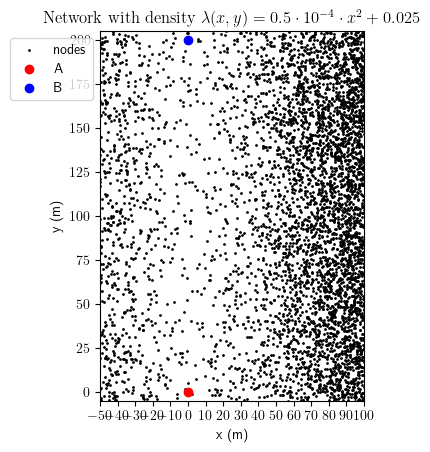

In [2]:
def lambd(x, y):
    return 0.5e-4 * x**2 + 0.025

def generate_points(num_points, x_bound, y_bound, density=lambd):
    points = []
    max_attempts = 9000
    max_density = max(density(x, y) for x in np.linspace(*x_bound, 100) for y in np.linspace(*y_bound, 100))

    for _ in range(num_points):
        for _ in range(max_attempts):
            x = np.random.uniform(*x_bound)
            y = np.random.uniform(*y_bound)
            if np.random.uniform(0, 1) < density(x, y) / max_density:
                points.append((x, y))
                break
    return points
    
def visualize_network(ax, points, source, destination):
    # fig, ax = plt.subplots()
    ax.set_title(r'$\mathrm{Network~with~density~} \lambda(x,y) = 0.5\cdot 10^{-4}\cdot x^2 + 0.025$')
    ax.scatter(points[:,0], points[:,1], s=1, color="black", label="nodes")
    ax.scatter([source[0]], [source[1]], color="red", label="A")
    ax.scatter([destination[0]], [destination[1]], color="blue", label="B")
    
    ax.set_xticks(np.arange(x_bound[0], x_bound[1]+1, 10))
    ax.set_xlim(x_bound[0], x_bound[1])
    ax.set_ylim(y_bound[0], y_bound[1])
    # ax.set_box_aspect((x_bound[1] - x_bound[0]) / (y_bound[1] - y_bound[0]))
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.legend(loc="best", bbox_to_anchor=(0, 1))
    return ax

num_points = 5000
points = generate_points(num_points, x_bound, y_bound, density=lambd)
print(len(points))
source = (0.0, 0.0)
destination = (0.0, 200.0)
points = np.array([source] + points + [destination])

fig, ax = plt.subplots()
ax = visualize_network(ax, points, source, destination)
plt.show()

### Variational Analysis

Use gradient descent to find the path $C$ from $a$ to $b$ which minimizes the action. 
$$ S(C) = \int_C n(r)~ds $$

static/problem_28.png


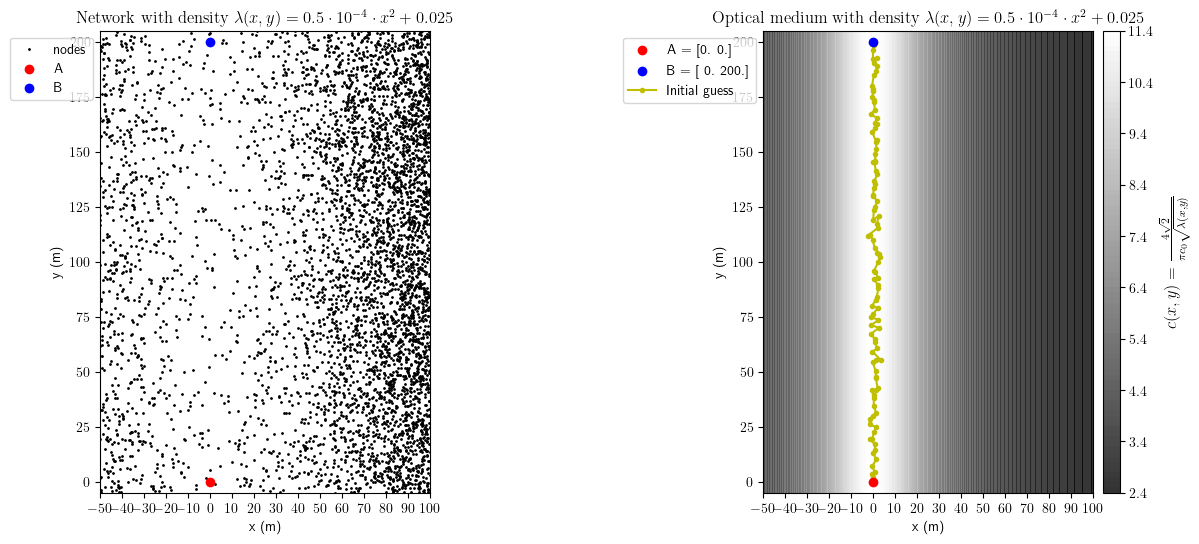

In [3]:
n = lambd

def c(x,y): # cost
    return 4 * np.sqrt(2) / (np.pi * torch.sqrt(n(x, y))) # divided by c_nominal = 1

def lagrangian_light(r): # Calculate the Lagrangian for light
    integral = 0
    for i in range(len(r) - 1):
        x1, y1 = r[i]
        x2, y2 = r[i + 1]
        ds = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        integral += c((x1+x2) / 2.0, (y1+y2) / 2.0) * ds
    return integral

# Define a function to optimize the optical path
def get_optical_path(r, steps=20000, step_size=1e-2, num_prints=8, num_stashes=80):
    As, print_on = [], np.linspace(0, int(np.sqrt(steps)), num_prints).astype(np.int32)**2
    rs, stash_on = [], np.linspace(0, int(np.sqrt(steps)), num_stashes).astype(np.int32)**2
    for i in range(steps):
        grad_r = torch.autograd.grad(lagrangian_light(r), r)[0] # compute gradient of lagrangian with respect to each point on path
        grad_r.data[[0, -1]] *= 0 # fix endpoints
        r.data -= grad_r * step_size # inch points on path away from gradient

        if i in print_on:
            A = lagrangian_light(r)
            As.append((i, A.item()))
            print(f"{i}/{steps}={i/steps}, A={As[-1][1]} J*s")
        if i in stash_on:
            rs.append(r.clone().detach().numpy())  # Use detach() before converting to NumPy
    return r.detach().numpy(), np.stack(rs), np.array(As)

num = 100
mesh_length = 2000
x_values = torch.linspace(x_bound[0], x_bound[1], mesh_length)
y_values = torch.linspace(y_bound[0], y_bound[1], mesh_length)
x_grid, y_grid = torch.meshgrid(x_values, y_values, indexing="ij")
c_values = c(x_grid, y_grid)

s = 1.0 # initially guess noisy line with small rightward semcircular bend to force solution on right side >99% instead of ~50%
x = torch.cos(torch.linspace(-np.pi/2, np.pi/2, num)) + torch.normal(0.0, s, (num,))
y = torch.linspace(source[1], destination[1], num) + torch.normal(0.0, s, (num,))
x[0], y[0], x[-1], y[-1] = source[0], source[1], destination[0], destination[1]
r0 = torch.stack([x, y], dim=1)

def visualize_medium(ax, r0, points, source, destination, fig=None):
    if fig is None:
        fig, ax = plt.subplots()
    ax.set_title(r'$\mathrm{Optical~medium~with~density~} \lambda(x,y) = 0.5\cdot 10^{-4}\cdot x^2 + 0.025$')
    cmap = plt.get_cmap('gray', num)
    contour = ax.contourf(x_grid, y_grid, c_values, cmap=cmap, levels=num, alpha=0.8)
    ax.scatter([r0[0,0]], [r0[0,1]], label=f"A = {r0[0].detach().numpy()}", color="red", zorder=100)
    ax.scatter([r0[-1,0]], [r0[-1,1]], label=f"B = {r0[-1].detach().numpy()}", color="blue", zorder=99)
    ax.plot(r0[:,0], r0[:,1], "y.-", label="Initial guess")
    
    ax.set_xticks(np.arange(x_bound[0], x_bound[1]+1, 10))
    ax.set_xlim(x_bound[0], x_bound[1])
    ax.set_ylim(y_bound[0], y_bound[1])
    # ax.set_box_aspect((x_bound[1] - x_bound[0]) / (y_bound[1] - y_bound[0]))
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.legend(loc="best", bbox_to_anchor=(0, 1))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    # cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
    cbar = fig.colorbar(contour, cax=cax)
    cbar.set_label(r'$c(x, y) = \frac{4\sqrt{2}}{\pi c_0 \sqrt{\lambda(x,y)}}$', fontsize=12)
    return ax

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0] = visualize_network(ax[0], points, source, destination)
ax[1] = visualize_medium(ax[1], r0, points, source, destination, fig=fig)
fname = f"static/problem_{str(datetime.now().minute)}.png"
print(fname)
plt.savefig(fname)
plt.show()

7100 steps
0/23000=0.0, A=2461.9287109375 J*s
441/23000=0.01917391304347826, A=2251.488525390625 J*s
1849/23000=0.08039130434782608, A=1626.52099609375 J*s
4096/23000=0.17808695652173914, A=1484.533203125 J*s
7396/23000=0.32156521739130434, A=1456.6632080078125 J*s
11449/23000=0.49778260869565216, A=1450.86767578125 J*s
16641/23000=0.7235217391304348, A=1449.6234130859375 J*s
22801/23000=0.9913478260869565, A=1451.342529296875 J*s
Computed optical path from [0. 0.] to [  0. 200.] with many hops
static/action.png


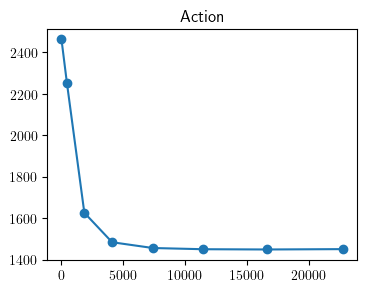

In [4]:
# Compute optical path between endpoints of given initial guess

steps = 7100
step_size = 0.25
print(f"{steps} steps")
ray, rs, As = get_optical_path(r0.clone().requires_grad_(), steps=23000, step_size=0.09)

print(f"Computed optical path from {ray[0]} to {ray[-1]} with many hops")
plt.figure(dpi=DPI, figsize=[4, 3])
plt.plot(As[:,0], As[:,1], "o-")
plt.title("Action")
fname = "static/action.png"
print(fname)
plt.savefig(fname)
plt.show()

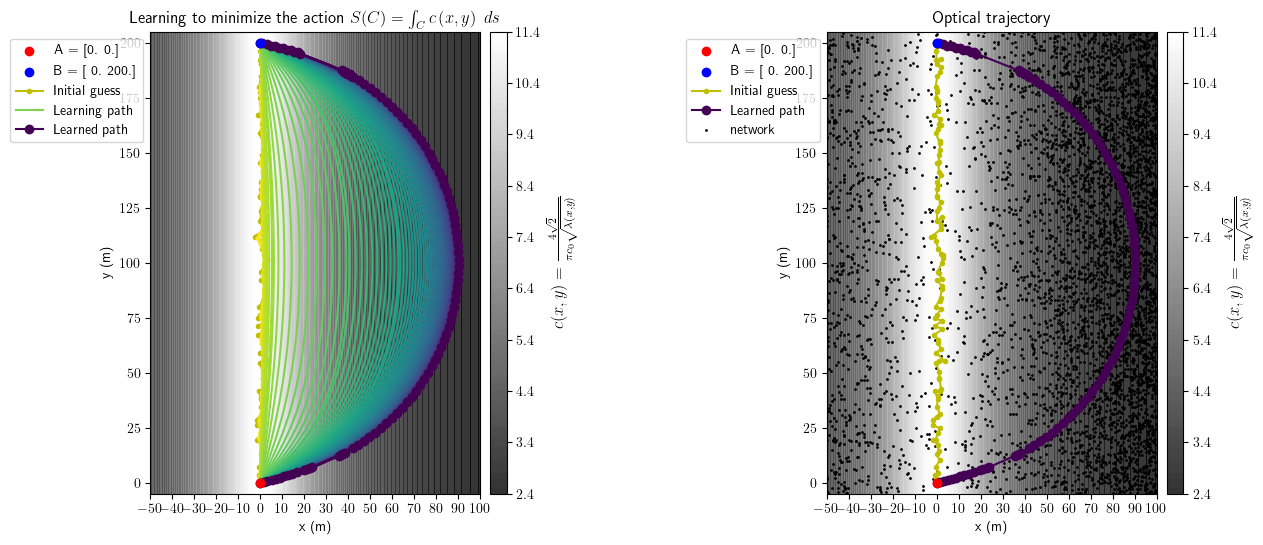

In [5]:
def visualize_optics(ax, r0, points, source, destination, fig=fig, training=True):
    ax = visualize_medium(ax, r0, points, source, destination, fig=fig)
    ax.set_title(r'Learning to minimize the action $S(C) = \int_C c\left(x,y\right)~ds$')
    if training:
        for i,ri in enumerate(rs):
            label = "Learning path" if i==15 else None
            ax.plot(ri[:,0], ri[:,1], color=plt.cm.viridis(1-i/(len(rs)-1)), label=label)
    ax.plot(ray[:,0], ray[:,1], "o-", color=plt.cm.viridis(0), label="Learned path")
    
    ax.set_xlim(x_bound[0], x_bound[1])
    ax.set_ylim(y_bound[0], y_bound[1])
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="best", bbox_to_anchor=(0, 1))
    return ax

def visualize_opnet(ax, r0, points, source, destination, fig=fig, training=False):
    ax = visualize_optics(ax, r0, points, source, destination, fig=fig, training=training)
    ax.set_title(r'Optical trajectory')
    ax.scatter(points[:,0], points[:,1], s=1, color="black", label="network")
    ax.legend(loc="best", bbox_to_anchor=(0, 1))
    return ax

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0] = visualize_optics(ax[0], r0, points, source, destination, fig=fig, training=True)
ax[1] = visualize_opnet(ax[1], r0, points, source, destination, fig=fig, training=False)
plt.savefig(f"static/ray_{str(datetime.now().minute)}.png")
plt.show()

### Make a video of the learning process

In [6]:
def film(rs_unlagged, path, interval=60, color="black", mode="ncf", **kwargs):
    rs = np.concatenate([rs_unlagged[:1]]*20 +[rs_unlagged] +[rs_unlagged[-1:]]*20 )
    fig = plt.gcf(); fig.set_dpi(200); fig.set_size_inches(5,4)
    camera = Camera(fig)
    cmap = plt.get_cmap('gray', num)
    plt.contourf(x_grid, y_grid, c_values, cmap=cmap, levels=num, alpha=1.0)
    for i in range(len(rs) if type(rs) is list else rs.shape[0]):
        if i % 10 == 0:
            print(i, len(rs))
        plt.contourf(x_grid, y_grid, c_values, cmap=cmap, levels=num, alpha=1.0)
        plt.title(f"Physics as network optimization ({i})")
        if mode == "ncf":
            for j, ri in enumerate(rs[:i]):
                plt.plot(ri[:, 0], ri[:, 1], alpha=0.15, color=plt.cm.viridis(1 - j / (len(rs) - 1)))
            plt.plot(rs[0][:, 0], rs[0][:, 1], alpha=0.15, color=plt.cm.viridis(1 - i / (len(rs) - 1)))
        plt.plot(rs[i][:, 0], rs[i][:, 1], color=color, markersize=15)
        plt.scatter([source[0]], [source[1]], c="red", label="Source")
        plt.scatter([destination[0]], [destination[1]], c="blue", marker='o', label="Destination", s=50)
        plt.xlim(x_bound[0], x_bound[1]); plt.ylim(y_bound[0], y_bound[1])
        plt.xlabel('x (m)') ; plt.ylabel('y (m)')
        camera.snap()
    anim = camera.animate(blit=True, interval=interval, **kwargs)
    print(f"Saving {path} ... ")
    anim.save(path)
    plt.close()

path = "static/film.mp4"

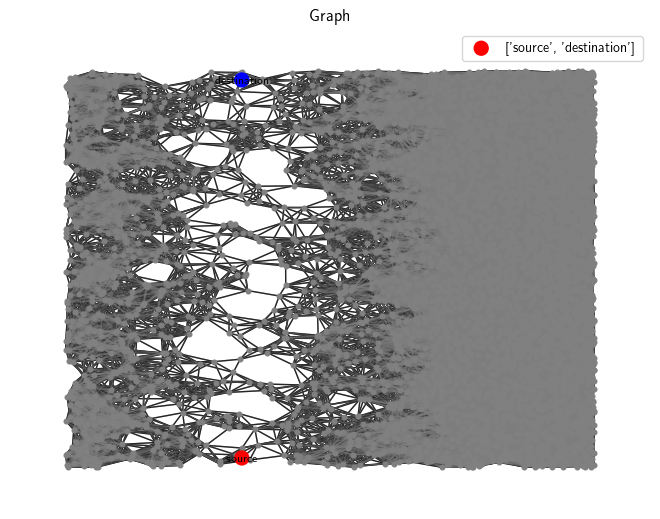

In [7]:
def cost_function(node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    d = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    a = 1.0
    b = 2.00
    f = 0.0  # 0.24
    return a * d**b + f


def create_graph(source, destination, points, distance=90):
    G = nx.Graph()
    G.add_node(tuple(source), pos=source)
    G.add_node(tuple(destination), pos=destination)
    for i, point in enumerate(points):
        G.add_node(tuple(point), pos=np.array(point))
    for u,u_data in G.nodes(data=True):
        u_pos = np.array(u_data['pos'])
        for v,v_data in G.nodes(data=True):
            v_pos = np.array(v_data['pos'])
            if u != v and np.linalg.norm(u_pos-v_pos) <= distance:
                cost = cost_function(u, v)
                G.add_edge(u,v, weight=cost)
    return G

dist = 19 # meters, whereas range of Bluetooth is 250-800
G = create_graph(source, destination, points, distance=11)
pos = nx.get_node_attributes(G, 'pos')

nx.draw(G, pos, with_labels=False, node_size=11, node_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray', alpha=0.3)
nx.draw_networkx_nodes(G, pos, nodelist=[source, destination], node_color=["red", "blue"], node_size=100, label=["source", "destination"])
labels = {source: "source", destination: "destination"}
nx.draw_networkx_labels(G, pos, labels, font_size=8)
plt.title("Graph")
plt.legend()
plt.grid(True)
plt.show()

# Trajectory-Based Forwarding

In [8]:
# Define a function to calculate the direction vector of the ray at a given point.
def target(ray, tail, i):
    j = i + 1
    if j < np.shape(ray)[0]:
        return ray[j]
    return np.array(destination)

def calculate_ray_direction(ray, tail, i):
    head = target(ray, tail, i)
    tangent = head-tail
    return tangent / np.linalg.norm(tangent)

# Define a function to compute the cost of transmission to a neighbor.
def cost_of_transmission(neighbor, current_node):
    return np.linalg.norm(neighbor - current_node) ** 2

def find_point_on_trajectory(node):
    return np.argmin(np.linalg.norm(ray-np.array(node), axis=1))

# Define a function to find the best neighbor to forward the packet based on the cost-progress ratio.
def find_best_neighbor(current_node, graph, points, i):
    best_neighbor = None
    best_cost_progress = 0 #float('inf')

    # Calculate the direction vector of the ray at the current point.
    ray_direction = calculate_ray_direction(ray, np.array(current_node), i)

    for neighbor in graph.neighbors(current_node):
        # Calculate the progress in the direction of the derivative of the current point in the ray.
        # neighbor_pos = graph.nodes[neighbor]['pos']
        v = np.array(neighbor) - np.array(current_node)
        cost = np.linalg.norm(v)
        v = v / cost
        progress = np.dot(v, ray_direction)
        cost_progress = progress / cost
        i = find_point_on_trajectory(neighbor)
        # print(f"Node {current_node}, {i}, {ray[i]} toward {ray[i+1]} by neighbor {neighbor}")

        if 0 <= cost_progress and cost_progress > best_cost_progress and neighbor not in computed_path:
            # Update the best neighbor if it minimizes the cost-progress ratio.
            best_neighbor = neighbor
            best_cost_progress = cost_progress
    return best_neighbor
# Define your network and data structures.
# You need to initialize variables such as current_node, destination, tolerance, and other parameters.

current_node = source  # Initial position as a tuple
tolerance = 1e-2  # Tolerance for considering the destination reached

# Initialize the current point index on the ray.
i = 0

# Lists to store computed path and points for visualization.
computed_path = [current_node]
obtfi = [find_point_on_trajectory(current_node)]
obtf = [ray[obtfi[-1]]]
all_points = [current_node]

cl = 0
# Main routing loop
while np.linalg.norm(np.array(current_node) - np.array(destination)) > tolerance:
    cl += 1
    if cl % 10 == 0:
        print(current_node)
    best_neighbor = find_best_neighbor(current_node, G, points, i)

    if best_neighbor is not None:
        # Forward the packet to the best_neighbor.
        i = find_point_on_trajectory(best_neighbor)
        current_node = best_neighbor
        computed_path.append(current_node)
        all_points.append(current_node)
        obtfi.append(i)
        obtf.append(ray[obtfi[-1]])

bellmanford = np.array(nx.shortest_path(G, source=tuple(source), target=tuple(destination), weight='weight', method="dijkstra"))
dijkstra = np.array(nx.shortest_path(G, source=tuple(source), target=tuple(destination), weight='weight', method="bellman-ford"))
print(len(computed_path))
print(np.shape(dijkstra))
print(np.shape(bellmanford))
print(sum(dijkstra-bellmanford))

(30.70632328387167, 7.285112418101949)
(45.039220236049346, 18.633459504503953)
(59.505304794493895, 30.175972850468362)
(69.72535310724149, 39.69774930247994)
(79.42068160467664, 53.706084704233014)
(83.08888860360798, 66.16028374831735)
(87.70071010189622, 76.11616147704724)
(89.8593275666365, 87.17653273054016)
(91.49112063329326, 101.01881544665389)
(90.69533511773122, 111.93248398732543)
(89.48727751633916, 121.95900551792174)
(86.31946105713294, 131.9314019629204)
(84.53591815325564, 139.71013246686445)
(75.9866623820355, 149.83817657921466)
(70.17601433698651, 157.1833963985819)
(61.33905523881478, 169.86609307894182)
(45.38894303221058, 180.5964823004711)
(22.141821692518192, 194.633947459132)
188
(229, 2)
(229, 2)
[0. 0.]


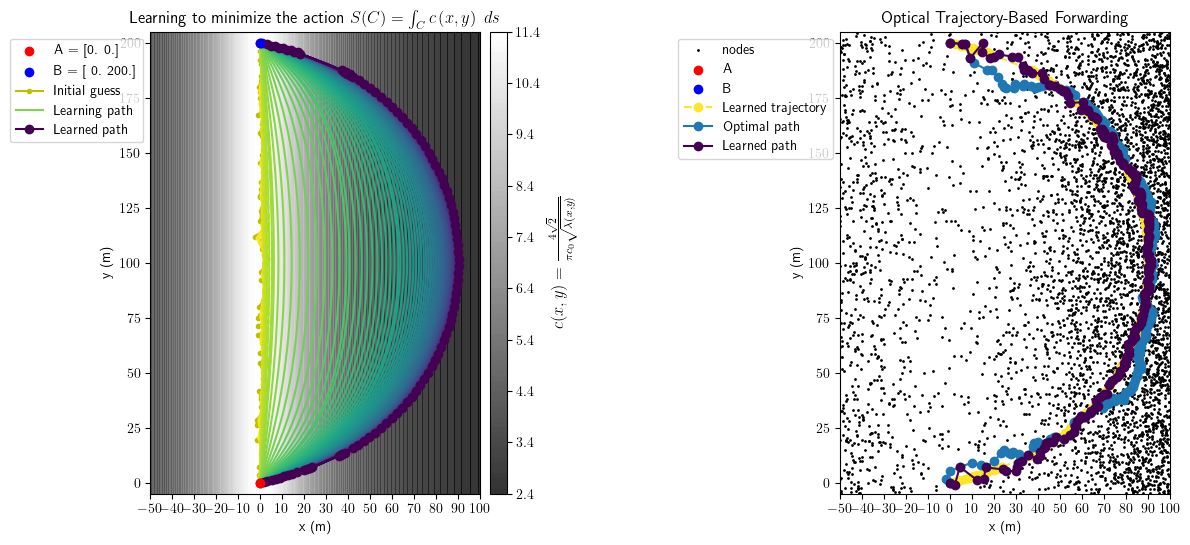

In [9]:
# The packet has reached the destination.

def visualize_light(ax, computed_path, d, bf, points, source, destination, fig=fig, training=False):
    ax = visualize_network(ax, points, source, destination)
    ax.set_title("Optical Trajectory-Based Forwarding")

    ray_points = np.array(ray)
    ax.plot(ray_points[:,0], ray_points[:,1], "o--", color=plt.cm.viridis(1.0), label="Learned trajectory", zorder=2)
    computed_path = np.array(computed_path)
    ax.plot(d[:,0], d[:,1], "o-", label="Optimal path")
    # ax.plot(bf[:,0], bf[:,1], "o-", label="Bellman-Ford")
    ax.plot(computed_path[:,0], computed_path[:,1], "o-", color=plt.cm.viridis(0), label="Learned path")
    
    ax.legend(loc="best", bbox_to_anchor=(0, 1))
    return ax

# Visualize the ray, computed path, and other elements as needed.
# plt.figure(figsize=(12, 9))
# plt.title("Ray Path Visualization")
# plt.xlabel("X-coordinate")
# plt.ylabel("y (m)")

# plt.scatter(points[:, 0], points[:, 1], s=10, label="All Points")

# # Plot the ray as a line
# ray_points = np.array(ray)
# plt.plot(ray_points[:, 0], ray_points[:, 1], linestyle="--", label="Ray", color="blue")

# # Plot the computed path as a line
# computed_path = np.array(computed_path)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0] = visualize_optics(ax[0], r0, points, source, destination, fig=fig, training=True)
ax[1] = visualize_light(ax[1], computed_path, dijkstra, bellmanford, points, source, destination, fig=fig, training=False)
plt.savefig(f"static/solution_{str(datetime.now().minute)}.png")
plt.show()

In [10]:
print(np.shape(rs))
film(rs, path, interval=91, color="blue")
t1 = time()
print(t1)
print(t1-t0)

(80, 100, 2)
0 120
10 120
20 120
30 120
40 120
50 120
60 120
70 120
80 120
90 120
100 120
110 120
Saving static/film.mp4 ... 
1701852090.7860272
761.4603085517883


In [11]:
mp4 = open(path, "rb").read()
url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("<video width=300 controls><source src='{}' type='video/mp4'></video>".format(url))